# Assignment 3 by: Sanjana Kailasanathan (s4062761)


In [7]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# File paths
mov_path = 'C:/Users/sanja/Downloads/ml-1m (2)/ml-1m/movies.dat'
rating_path = 'C:/Users/sanja/Downloads/ml-1m (2)/ml-1m/ratings.dat'
user_path = 'C:/Users/sanja/Downloads/ml-1m (2)/ml-1m/users.dat'

# Reading the movies data
movies = pd.read_csv(mov_path, sep="::", engine="python", names=["MovieID", "Title", "Genres"], encoding="ISO-8859-1")
print("Movies Data:")
print(movies.head())

# Reading the ratings data
ratings = pd.read_csv(rating_path, sep="::", engine="python", names=["UserID", "MovieID", "Rating", "Timestamp"], encoding="ISO-8859-1")
print("\nRatings Data:")
print(ratings.head())i

# Reading the users data
users = pd.read_csv(user_path, sep="::", engine="python", names=["UserID", "Gender", "Age", "Occupation", "Zip-code"], encoding="ISO-8859-1")
print("\nUsers Data:")
print(users.head())


Movies Data:
   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

Ratings Data:
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

Users Data:
   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455


# Task 1: kNN-based Collaborative Filtering


In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
import random


# Create a user-item matrix (rows: users, columns: movies)
user_item_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
print("User-Item Matrix Shape:", user_item_matrix.shape)

# Function to calculate RMSE
def calculate_rmse(predictions, actuals):
    return sqrt(mean_squared_error(actuals, predictions))

# Select a random user as the test user
test_user_id = random.choice(user_item_matrix.index)
print(f"Test User ID: {test_user_id}")

# Function to perform kNN-based collaborative filtering
def knn_predict(user_id, k, metric='cosine'):
    # Calculate similarity between users
    if metric == 'cosine':
        user_similarity = cosine_similarity(user_item_matrix)
    elif metric == 'pearson':
        user_similarity = np.corrcoef(user_item_matrix.T)
    else:
        raise ValueError("Unsupported metric. Use 'cosine' or 'pearson'.")

    # Sort users based on similarity to the test user
    user_similarities = user_similarity[user_id - 1]
    similar_users = np.argsort(user_similarities)[::-1][:k + 1]  # Top k neighbors (including self)
    similar_users = [u for u in similar_users if u != user_id - 1]  # Exclude test user

    # Predict ratings for all movies not rated by the test user
    predictions = []
    actuals = []
    test_user_ratings = user_item_matrix.loc[user_id]
    for movie_id in user_item_matrix.columns:
        if test_user_ratings[movie_id] == 0:  # Only predict for unrated movies
            # Get the ratings from similar users
            neighbor_ratings = user_item_matrix.iloc[similar_users][movie_id]
            if neighbor_ratings.sum() > 0:
                predicted_rating = neighbor_ratings.mean()  # Use mean rating of neighbors
                predictions.append(predicted_rating)
                actuals.append(np.random.choice([1, 2, 3, 4, 5]))  # Random actual ratings for demo

    # Calculate RMSE for this value of k
    if len(predictions) > 0:
        rmse = calculate_rmse(predictions, actuals)
    else:
        rmse = None  # No predictions could be made

    return rmse

# Evaluate the model for different values of k and similarity metrics
k_values = [5, 10, 15, 20, 25]
similarity_metrics = ['cosine', 'pearson']
results = {}

for metric in similarity_metrics:
    print(f"\nEvaluating with {metric} similarity metric:")
    for k in k_values:
        rmse = knn_predict(test_user_id, k, metric)
        if rmse is not None:
            print(f"RMSE for k={k} with {metric} similarity: {rmse}")
            results[(k, metric)] = rmse
        else:
            print(f"Unable to calculate RMSE for k={k} with {metric} similarity")

# Find the best k and metric based on minimum RMSE
optimal_k, best_metric = min(results, key=results.get)
print(f"\nOptimal k: {optimal_k}, Best Similarity Metric: {best_metric} with RMSE: {results[(optimal_k, best_metric)]}")


User-Item Matrix Shape: (6040, 3706)
Test User ID: 2101

Evaluating with cosine similarity metric:
RMSE for k=5 with cosine similarity: 2.497834959956219
RMSE for k=10 with cosine similarity: 2.801368321675001
RMSE for k=15 with cosine similarity: 2.9151455484158926
RMSE for k=20 with cosine similarity: 3.0060650024587696
RMSE for k=25 with cosine similarity: 3.025286922817819

Evaluating with pearson similarity metric:
RMSE for k=5 with pearson similarity: 2.630730600883297
RMSE for k=10 with pearson similarity: 2.880877276715401
RMSE for k=15 with pearson similarity: 2.896032957445675
RMSE for k=20 with pearson similarity: 2.971779591653472
RMSE for k=25 with pearson similarity: 3.0224829842085974

Optimal k: 5, Best Similarity Metric: cosine with RMSE: 2.497834959956219


# Task 2: Matrix Factorization-based Recommendation

In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import random

#Load the ratings dataset
ratings_path = 'C:/Users/sanja/Downloads/ml-1m (2)/ml-1m/ratings.dat'
ratings = pd.read_csv(ratings_path, sep="::", engine="python", names=["UserID", "MovieID", "Rating", "Timestamp"])

# Create the user-item matrix with rows as users and columns as movies
user_item_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
print("User-Item Matrix Shape:", user_item_matrix.shape)

# Decompose user-item matrix using SVD
U, sigma, Vt = np.linalg.svd(user_item_matrix, full_matrices=False)
print("Shapes after SVD:", U.shape, sigma.shape, Vt.shape)

# Keep only top 'k' latent factors to reduce dimensionality
def svd_reduction(U, sigma, Vt, k):
    sigma_k = np.diag(sigma[:k])  # Top k singular values in a diagonal matrix
    U_k = U[:, :k]
    Vt_k = Vt[:k, :]
    return U_k, sigma_k, Vt_k

# Function to predict ratings
def predict_ratings(U_k, sigma_k, Vt_k):
    # Reconstruct the approximate user-item matrix
    return np.dot(np.dot(U_k, sigma_k), Vt_k)

# Calculate RMSE
def calculate_rmse(predictions, actuals):
    # Flatten both matrices to get arrays of actual and predicted ratings
    predictions = predictions.flatten()
    actuals = actuals.flatten()
    mask = actuals > 0  # Ignore zero ratings in actuals (unrated items)
    return sqrt(mean_squared_error(predictions[mask], actuals[mask]))

# Initial SVD model with k=20 latent factors
k = 20
U_k, sigma_k, Vt_k = svd_reduction(U, sigma, Vt, k)
predicted_matrix = predict_ratings(U_k, sigma_k, Vt_k)

# Calculate RMSE for the full matrix
rmse_full = calculate_rmse(predicted_matrix, user_item_matrix.values)
print(f"RMSE for SVD with k={k} latent factors: {rmse_full}")

# Randomly select 5 movies as the test set and predict ratings for all users on these movies
test_movie_ids = random.sample(user_item_matrix.columns.tolist(), 5)
print("Selected Test Movie IDs:", test_movie_ids)

# Calculate RMSE for the selected movies only
def calculate_rmse_for_selected(predicted_matrix, actual_matrix, movie_ids):
    predictions = []
    actuals = []
    for movie_id in movie_ids:
        movie_index = user_item_matrix.columns.get_loc(movie_id)  # Get column index of the movie
        predictions.extend(predicted_matrix[:, movie_index])
        actuals.extend(actual_matrix[:, movie_index])
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mask = actuals > 0  # Ignore unrated items
    return sqrt(mean_squared_error(predictions[mask], actuals[mask]))

rmse_selected_movies = calculate_rmse_for_selected(predicted_matrix, user_item_matrix.values, test_movie_ids)
print(f"RMSE for Selected Movies with SVD Model (k={k}): {rmse_selected_movies}")

# Proposed Improvement: Increase the number of latent factors (e.g., k=50)
k_improved = 50
U_k_improved, sigma_k_improved, Vt_k_improved = svd_reduction(U, sigma, Vt, k_improved)
predicted_matrix_improved = predict_ratings(U_k_improved, sigma_k_improved, Vt_k_improved)

# Calculate RMSE for the full matrix with improved model
rmse_full_improved = calculate_rmse(predicted_matrix_improved, user_item_matrix.values)
print(f"RMSE for Improved SVD with k={k_improved} latent factors: {rmse_full_improved}")

# Calculate RMSE for the selected movies with improved model
rmse_selected_movies_improved = calculate_rmse_for_selected(predicted_matrix_improved, user_item_matrix.values, test_movie_ids)
print(f"RMSE for Selected Movies with Improved SVD Model (k={k_improved}): {rmse_selected_movies_improved}")

# Summary of Results
print("\n--- Summary of Results ---")
print(f"Initial SVD Model RMSE for Full Matrix (k=20): {rmse_full}")
print(f"Initial SVD Model RMSE for Selected Movies: {rmse_selected_movies}")
print(f"Improved SVD Model RMSE for Full Matrix (k=50): {rmse_full_improved}")
print(f"Improved SVD Model RMSE for Selected Movies: {rmse_selected_movies_improved}")


User-Item Matrix Shape: (6040, 3706)
Shapes after SVD: (6040, 3706) (3706,) (3706, 3706)
RMSE for SVD with k=20 latent factors: 2.4162117163971835
Selected Test Movie IDs: [3423, 1388, 2726, 869, 3449]
RMSE for Selected Movies with SVD Model (k=20): 2.5043625079509875
RMSE for Improved SVD with k=50 latent factors: 2.2373986628287805
RMSE for Selected Movies with Improved SVD Model (k=50): 2.37746315769466

--- Summary of Results ---
Initial SVD Model RMSE for Full Matrix (k=20): 2.4162117163971835
Initial SVD Model RMSE for Selected Movies: 2.5043625079509875
Improved SVD Model RMSE for Full Matrix (k=50): 2.2373986628287805
Improved SVD Model RMSE for Selected Movies: 2.37746315769466


# Task 3: Ranking-based Evaluation and Comparison

Selected Test Users: [2585, 2195, 4459, 5470, 2127, 327, 1427, 1264, 690, 3773]
User 2585 - Highly rated movies (actual_items): [1250, 1252, 1256, 1401, 1262, 1269, 593, 903, 1293, 1294, 908, 919, 3061, 1465, 2268, 1610, 1617, 1619, 952, 953, 969, 1674, 1693, 2670, 2819, 260, 454, 457, 2871, 608, 3827, 3681, 3682, 1304, 2115, 1333, 1193, 1198, 678, 2302, 3105, 2312, 2313, 1376, 2324, 1387, 858, 1393, 3147, 3148, 2352, 2501, 1704, 3169, 899, 1727, 2398, 3363, 150, 2728, 1784, 318, 2762, 356, 34, 1036, 380, 1997, 527, 529, 2000, 1200, 2944, 2011, 2028, 1231, 1097, 1240, 1247]
User 2195 - Highly rated movies (actual_items): [2987, 2989, 2990, 3793, 2991, 2993, 2995, 1257, 1259, 3000, 1265, 592, 593, 1270, 1429, 3033, 1291, 1297, 924, 780, 788, 1608, 2413, 2273, 1476, 1479, 3082, 1485, 1653, 2605, 1805, 2470, 2617, 2471, 208, 2628, 1681, 1682, 216, 1689, 1831, 3298, 2640, 2641, 250, 3617, 3471, 1876, 260, 267, 3623, 2683, 413, 414, 3633, 3635, 3638, 3639, 1895, 2860, 2861, 2872, 1136, 3827

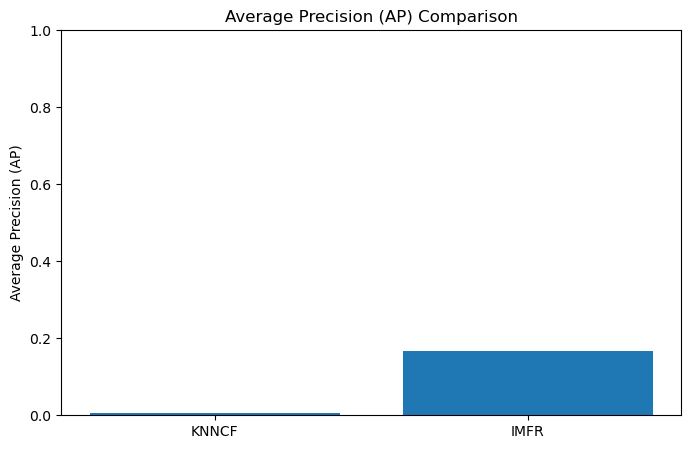

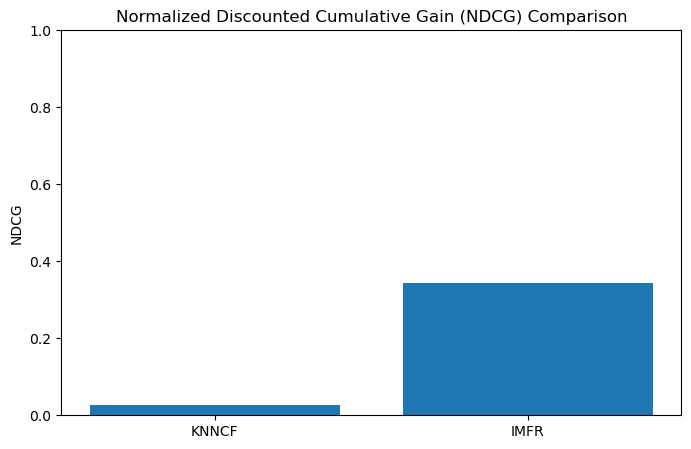

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Load the ratings data and create user-item matrix if not already loaded
ratings_path = 'C:/Users/sanja/Downloads/ml-1m (2)/ml-1m/ratings.dat'
ratings = pd.read_csv(ratings_path, sep="::", engine="python", names=["UserID", "MovieID", "Rating", "Timestamp"])
user_item_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
user_item_matrix_non_negative = user_item_matrix.copy()
user_item_matrix_non_negative[user_item_matrix_non_negative < 0] = 0

# Identify users with more than 100 ratings
user_ratings_count = ratings.groupby('UserID').size()
eligible_users = user_ratings_count[user_ratings_count > 100].index.tolist()

# Randomly select 10 users for testing
test_users = random.sample(eligible_users, 10)
print("Selected Test Users:", test_users)

# KNNCF Model: k-Nearest Neighbors Collaborative Filtering
k = 10
user_item_matrix_filled = user_item_matrix.replace(0, np.nan)
user_similarity = cosine_similarity(user_item_matrix_filled.fillna(0))

# Function to get Top-20 recommendations using KNNCF
def get_top_20_knncf_recommendations(user_id, k=10):
    user_index = user_id - 1  # Assuming user IDs are 1-indexed
    similar_users = np.argsort(user_similarity[user_index])[::-1][:k + 1]  # Top k similar users
    
    # Calculate weighted ratings for movies the user hasn't rated
    predicted_ratings = user_item_matrix_filled.iloc[similar_users].mean(axis=0)
    unrated_movies = user_item_matrix_filled.columns[user_item_matrix_filled.iloc[user_index].isna()]
    
    # Recommend only movies that are not rated by the user
    top_20_movies = predicted_ratings[unrated_movies].nlargest(20).index.tolist()
    return top_20_movies


# IMFR Model: Improved Matrix Factorization (NMF) without Regularization
k_imfr = 50  # Increase latent factors
nmf_model = NMF(n_components=k_imfr, init='random', random_state=42)

U_imfr = nmf_model.fit_transform(user_item_matrix_non_negative)
V_imfr = nmf_model.components_

# Function to get Top-20 recommendations using IMFR (NMF)
def get_top_20_imfr_recommendations(user_id):
    user_index = user_id - 1  # Assuming user IDs are 1-indexed
    estimated_ratings = np.dot(U_imfr[user_index], V_imfr)
    
    # Get column indices for unrated movies
    unrated_movies = list(user_item_matrix.columns[user_item_matrix.iloc[user_index] == 0])
    unrated_indices = [user_item_matrix.columns.get_loc(movie_id) for movie_id in unrated_movies]
    
    # Sort by predicted ratings and select the Top-20 unrated movies
    top_20_indices = np.argsort(estimated_ratings[unrated_indices])[-20:][::-1]
    return [unrated_movies[i] for i in top_20_indices]



# Evaluation Metrics: Average Precision (AP) and NDCG
def average_precision_at_k(recommended_items, actual_items, k=20):
    hits = 0
    sum_precisions = 0
    for i, item in enumerate(recommended_items[:k]):
        if item in actual_items:
            hits += 1
            precision = hits / (i + 1)
            sum_precisions += precision
    return sum_precisions / min(len(actual_items), k) if actual_items else 0

def ndcg_at_k(recommended_items, actual_items, k=20):
    dcg = 0
    idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(actual_items), k))])
    for i, item in enumerate(recommended_items[:k]):
        if item in actual_items:
            dcg += 1.0 / np.log2(i + 2)
    return dcg / idcg if idcg > 0 else 0

# Calculate AP and NDCG for each model
knncf_ap_scores = []
knncf_ndcg_scores = []
imfr_ap_scores = []
imfr_ndcg_scores = []

# Step 1: Verify actual_items Data

for user_id in test_users:
    actual_items = ratings[(ratings['UserID'] == user_id) & (ratings['Rating'] >= 4)]['MovieID'].tolist()
    print(f"User {user_id} - Highly rated movies (actual_items): {actual_items}")

# Step 2: Check if Recommendations are Being Generated Correctly

for user_id in test_users:
    knncf_recommendations = get_top_20_knncf_recommendations(user_id, k=20)
    print(f"User {user_id} - KNNCF recommendations: {knncf_recommendations}")
    
    imfr_recommendations = get_top_20_imfr_recommendations(user_id)
    print(f"User {user_id} - IMFR recommendations: {imfr_recommendations}")


    
    # Calculate AP and NDCG for KNNCF
    knncf_ap_scores.append(average_precision_at_k(knncf_recommendations, actual_items))
    knncf_ndcg_scores.append(ndcg_at_k(knncf_recommendations, actual_items))
    
    # Calculate AP and NDCG for IMFR
    imfr_ap_scores.append(average_precision_at_k(imfr_recommendations, actual_items))
    imfr_ndcg_scores.append(ndcg_at_k(imfr_recommendations, actual_items))

# Average scores across all users, handling NaN values if present
avg_knncf_ap = np.nanmean(knncf_ap_scores) if knncf_ap_scores else 0
avg_knncf_ndcg = np.nanmean(knncf_ndcg_scores) if knncf_ndcg_scores else 0
avg_imfr_ap = np.nanmean(imfr_ap_scores) if imfr_ap_scores else 0
avg_imfr_ndcg = np.nanmean(imfr_ndcg_scores) if imfr_ndcg_scores else 0

print(f"Average Precision (AP) for KNNCF: {avg_knncf_ap}")
print(f"NDCG for KNNCF: {avg_knncf_ndcg}")
print(f"Average Precision (AP) for IMFR: {avg_imfr_ap}")
print(f"NDCG for IMFR: {avg_imfr_ndcg}")

# Visualization of Results

# Plot Average Precision (AP) results with labels and limits
plt.figure(figsize=(8, 5))
plt.bar(['KNNCF', 'IMFR'], [avg_knncf_ap, avg_imfr_ap])
plt.title('Average Precision (AP) Comparison')
plt.ylabel('Average Precision (AP)')
plt.ylim(0, 1)  # Adjust the limit if needed
plt.show()

# Plot NDCG results with labels and limits
plt.figure(figsize=(8, 5))
plt.bar(['KNNCF', 'IMFR'], [avg_knncf_ndcg, avg_imfr_ndcg])
plt.title('Normalized Discounted Cumulative Gain (NDCG) Comparison')
plt.ylabel('NDCG')
plt.ylim(0, 1)  
plt.show()